# Term Deposit Opening Decision

## import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import FactorAnalysis
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

In [2]:
#read csv file

df=pd.read_csv("/Users/gulcanogundur/Desktop/Big Data Projelerim/bank-additional-full.csv",sep=";")

# Descriptive Analysis

In [3]:
print("Describe Dataset","\n")
print(df.info())
print(df.head(10))
print(df.describe())


Describe Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), ob

## Continuous Variables

In [4]:
print("Continuous Variables","\n")
continous_vars=df.describe().columns
print(continous_vars)

Continuous Variables 

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


In [5]:
print("Categorical Variables","\n")
categorical_vars=df.describe(include=[object]).columns
print(categorical_vars)

Categorical Variables 

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


## Visualizing - Continous Variables

Continuous Variables Visualization 



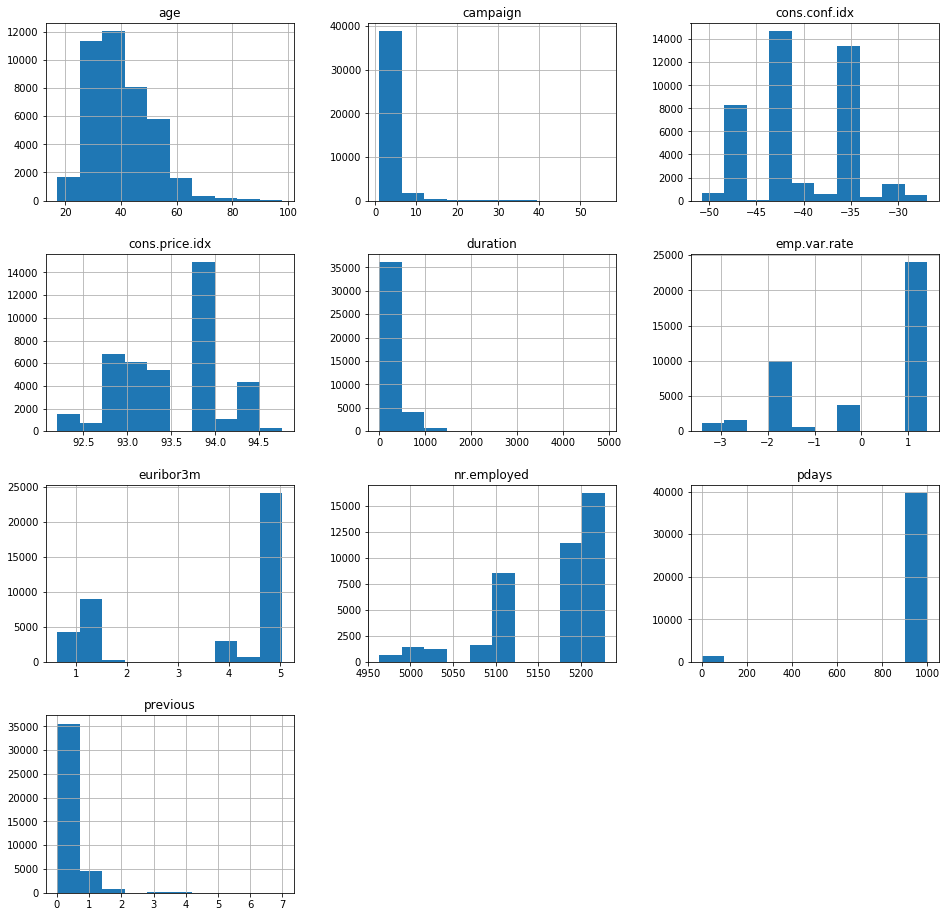

In [7]:
print("Continuous Variables Visualization","\n")
df.hist(column=continous_vars,figsize=(16,16))
plt.show()

## Visualizing - Categorical Variables

Categorical Variables Visualization 



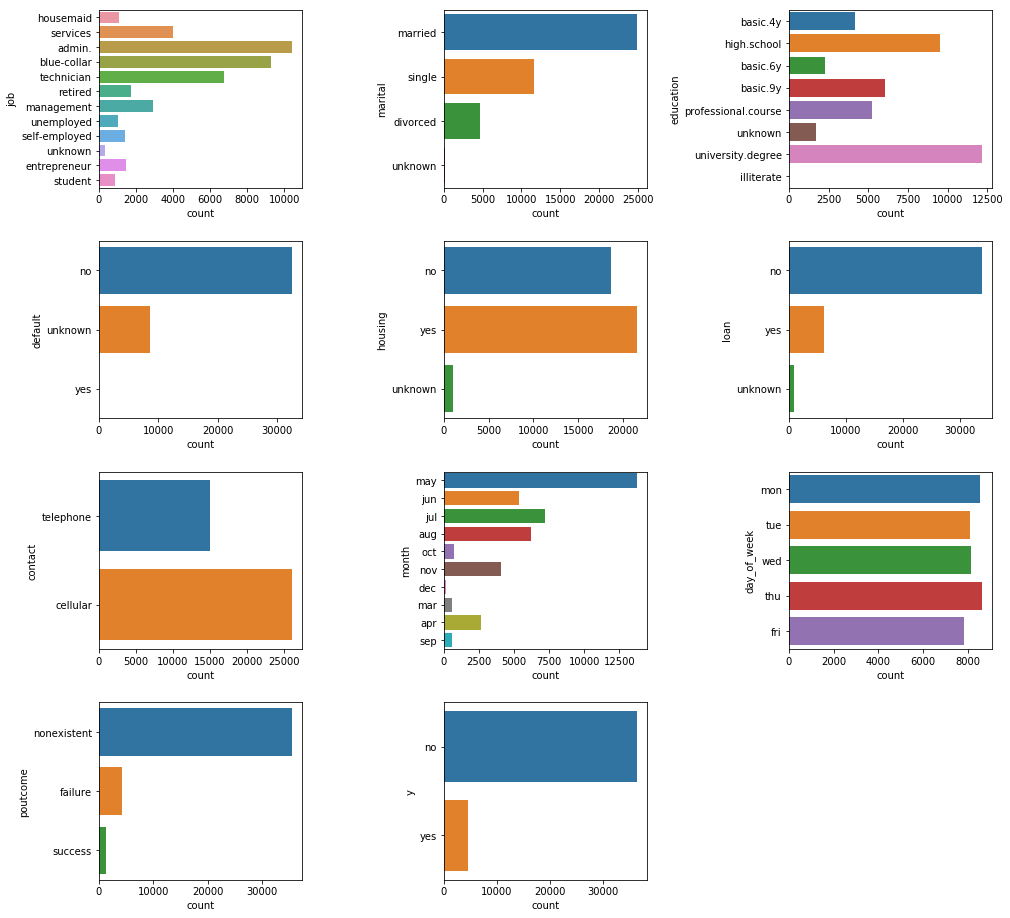

In [8]:
print("Categorical Variables Visualization","\n")
fig, axes = plt.subplots(4, 3, figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)
for i, ax in enumerate(axes.ravel()):
    if i > 10:
        ax.set_visible(False)
        continue
    sns.countplot(y = categorical_vars[i], data=df, ax=ax)
plt.show()

## Data Manipulation

In [9]:
# Convert pdays column numeric to categorical    
df["pdays_cat"]=[0 if each==999  else 1 for each in df.pdays]
df=df.drop(["pdays"],axis=1)

## Correlations

Correlation Matrix 



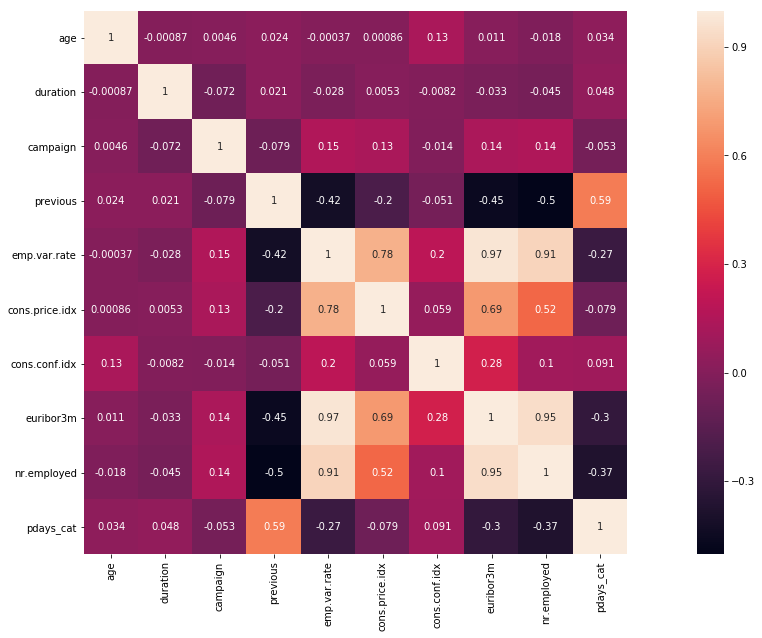

In [10]:
#Heat map
print("Correlation Matrix","\n")    
correlation=df.corr(method="pearson")
plt.figure(figsize=(25,10))
sns.heatmap(correlation,vmax=1,square=True,annot=True)
plt.show()

# Factor Analysis

In [11]:
fact_2c=FactorAnalysis(n_components=1)
df["X_factor"]=fact_2c.fit_transform(df[['euribor3m','nr.employed','cons.price.idx','emp.var.rate']])
df=df.drop(["euribor3m","nr.employed","cons.price.idx","emp.var.rate"],axis=1)


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


## One - Hot Encoding

In [12]:
columns = df.select_dtypes(include=[object]).columns
df = pd.concat([df, pd.get_dummies(df[columns])], axis=1)
df = df.drop(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week','poutcome', 'y','duration'], axis =1)
print("\n","Describe Dataset_v2","\n")
print(df.info(),"\n \n \n")


 Describe Dataset_v2 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 61 columns):
age                              41188 non-null int64
campaign                         41188 non-null int64
previous                         41188 non-null int64
cons.conf.idx                    41188 non-null float64
pdays_cat                        41188 non-null int64
X_factor                         41188 non-null float64
job_admin.                       41188 non-null uint8
job_blue-collar                  41188 non-null uint8
job_entrepreneur                 41188 non-null uint8
job_housemaid                    41188 non-null uint8
job_management                   41188 non-null uint8
job_retired                      41188 non-null uint8
job_self-employed                41188 non-null uint8
job_services                     41188 non-null uint8
job_student                      41188 non-null uint8
job_technician                   41188 non-null uint8

## Data Normalization

In [13]:
min_max_scaler=preprocessing.MinMaxScaler()
data_scaled=pd.DataFrame(min_max_scaler.fit_transform(df),columns=df.columns)

In [14]:
y = data_scaled.y_yes
data_scaled = data_scaled.drop(['y_yes','y_no'], axis = 1)

## Test - Train Data Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, y, test_size=0.2, random_state=42)

## Upsampling

In [16]:
def upSample(X_train, y_train):
    df_all = pd.concat((X_train, pd.DataFrame({'value': y_train}, index=y_train.index)), axis=1)
    
    df_majority = df_all [df_all.value==0]
    df_minority = df_all[df_all.value==1]
     
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=df_majority.shape[0],    # to match majority class
                                     random_state=123) # reproducible results
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled], axis=0)
    y_upsampled = df_upsampled.value
    X_upsampled = df_upsampled.drop('value', axis=1)

    return X_upsampled, y_upsampled

## Logistic Regression

In [17]:
X_train,y_train=upSample(X_train, y_train)
lr = LogisticRegression(random_state = 42)
lr.fit(X_train,y_train)
prediction = lr.predict(X_test)
print("Logistic Regression","\n")
print("Classification Report","\n")
print(classification_report(y_test, prediction))

Logistic Regression 

Classification Report 

             precision    recall  f1-score   support

        0.0       0.95      0.84      0.89      7303
        1.0       0.33      0.63      0.44       935

avg / total       0.88      0.82      0.84      8238



## Confusion Matrix

Confusion Matrix 



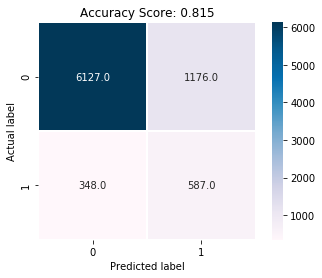

In [18]:
print("Confusion Matrix","\n")
score = round(accuracy_score(y_test, prediction),3) 
cm1 = cm(y_test, prediction)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'PuBu')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

# Feature Selection

In [19]:
rfe=RFE(lr,10)
rfe=rfe.fit(X_train,y_train)
print("Feature Selection","\n")
print(X_train[X_train.columns[rfe.ranking_==1].values].columns,"\n")

Feature Selection 

Index(['campaign', 'previous', 'cons.conf.idx', 'pdays_cat', 'X_factor',
       'education_illiterate', 'month_mar', 'month_may', 'month_oct',
       'poutcome_failure'],
      dtype='object') 



## Cross Validation

In [20]:
accuracies = cross_val_score(estimator = lr, X = X_train, y = y_train, cv = 10)
print("Accuracy (mean): %",accuracies.mean()*100)
print("std: %",accuracies.std()*100)

Accuracy (mean): % 74.1203824523
std: % 0.624419755001


In [21]:
scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=10,)
print ("MAE (mean): %" , scores.mean())

MAE (mean): % -0.258796175477


## Errors

In [22]:
mae = mean_absolute_error(lr.predict(X_test), y_test)
mse = mean_squared_error(lr.predict(X_test), y_test)
rmse = np.sqrt(mse)
print('Mean Absolute Error (MAE): %.2f' % mae)
print('Mean Squared Error (MSE): %.2f' % mse)
print('Root Mean Squared Error (RMSE): %.2f' % rmse)

Mean Absolute Error (MAE): 0.18
Mean Squared Error (MSE): 0.18
Root Mean Squared Error (RMSE): 0.43


## Cohen - Matthew Score

In [23]:
print("Cohen Score",cohen_kappa_score(y_test, prediction))
print("Matthew Score",matthews_corrcoef(y_test, prediction))

Cohen Score 0.336758215327
Matthew Score 0.361011121079


## K Nearest Neighbors

In [30]:
classifier = KNeighborsClassifier(n_neighbors=100,weights="distance")  
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  

print("KNN Algorithm")
print("Classification Report")
print(classification_report(y_test, y_pred)) 

KNN Algorithm
Classification Report
             precision    recall  f1-score   support

        0.0       0.93      0.82      0.87      7303
        1.0       0.28      0.55      0.37       935

avg / total       0.86      0.79      0.82      8238



Confusion Matrix 



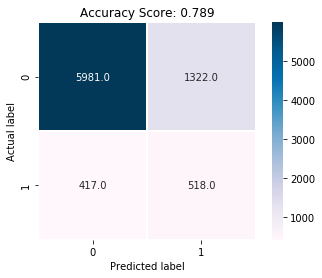

In [31]:
print("Confusion Matrix","\n")
score = round(accuracy_score(y_test, y_pred),3) 
cm1 = cm(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'PuBu')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

In [ ]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy (mean): %",accuracies.mean()*100)
print("std: %",accuracies.std()*100)

scores = cross_val_score(classifier, X_train, y_train, scoring='neg_mean_absolute_error', cv=10,)
print ("MAE (mean): %" , scores.mean())
print("\n")

In [32]:
mae = mean_absolute_error(classifier.predict(X_test), y_test)
mse = mean_squared_error(classifier.predict(X_test), y_test)
rmse = np.sqrt(mse)
print('Mean Absolute Error (MAE): %.2f' % mae)
print('Mean Squared Error (MSE): %.2f' % mse)
print('Root Mean Squared Error (RMSE): %.2f' % rmse)
print("\n")

Mean Absolute Error (MAE): 0.21
Mean Squared Error (MSE): 0.21
Root Mean Squared Error (RMSE): 0.46




In [33]:
print("Cohen Score",cohen_kappa_score(y_test, y_pred))
print("Matthew Score",matthews_corrcoef(y_test, y_pred))


Cohen Score 0.262299680993
Matthew Score 0.284067585545


## Random Forest

In [24]:
rf = RandomForestClassifier(n_estimators=10 ,n_jobs=-1,
                            random_state=42, 
                            max_depth= 5
                           # class_weight="balanced",
                            #max_features=10)
                            )

rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
print("Random Forest Algorithm","\n")
print("Classification Report","\n")
print(classification_report(y_test, rf_predict))

Random Forest Algorithm 

Classification Report 

             precision    recall  f1-score   support

        0.0       0.95      0.83      0.88      7303
        1.0       0.32      0.63      0.43       935

avg / total       0.88      0.81      0.83      8238



Confusion Matrix 



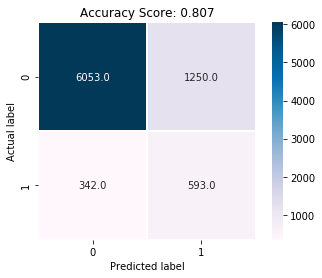

In [25]:
print("Confusion Matrix","\n")
score = round(accuracy_score(y_test, rf_predict),3)
cm1 = cm(y_test, rf_predict)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
            square = True, cmap = 'PuBu')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

In [26]:
accuracies = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10)
print("Accuracy (mean): %",accuracies.mean()*100)
print("std: %",accuracies.std()*100)

scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=10,)
print ("MAE (mean): %" , scores.mean())
print("\n")

Accuracy (mean): % 74.301591895
std: % 0.657612294845
MAE (mean): % -0.25698408105




In [27]:
mae = mean_absolute_error(rf.predict(X_test), y_test)
mse = mean_squared_error(rf.predict(X_test), y_test)
rmse = np.sqrt(mse)
print('Mean Absolute Error (MAE): %.2f' % mae)
print('Mean Squared Error (MSE): %.2f' % mse)
print('Root Mean Squared Error (RMSE): %.2f' % rmse)
print("\n")

Mean Absolute Error (MAE): 0.19
Mean Squared Error (MSE): 0.19
Root Mean Squared Error (RMSE): 0.44




In [28]:
print("Cohen Score",cohen_kappa_score(y_test, rf_predict))
print("Matthew Score",matthews_corrcoef(y_test, rf_predict))
print("\n")

Cohen Score 0.32532218886
Matthew Score 0.352462336608




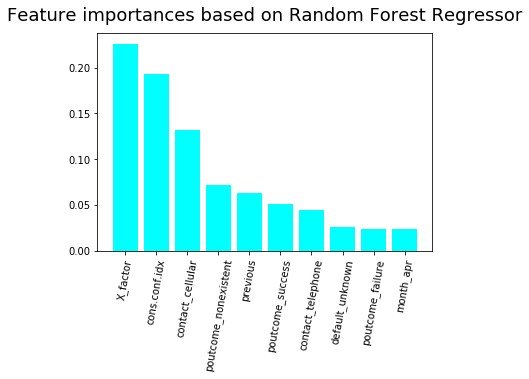

In [29]:
ranking = rf.feature_importances_
features = np.argsort(ranking)[::-1][:10]
columns = data_scaled.columns
plt.title("Feature importances based on Random Forest Regressor", y = 1.03, size = 18)
plt.bar(range(len(features)), ranking[features], color="aqua", align="center")
plt.xticks(range(len(features)), columns[features], rotation=80)
plt.show()